In [1]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import filterpy.stats as stats

In [3]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [4]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [5]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)
def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

### First Kalman Filter

Let's get back to concrete terms and implement a Kalman filter. We've implemented the update() and predict() functions. We just need to write some boilerplate code to simulate a dog and create the measurements. I've put a DogSimulation class in kf_internal to avoid getting distracted with that task.

This boilerplate code sets up the problem by definine the means, variances, and generating the simulated dog movement.

In [6]:
np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) 

In [7]:
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

In [8]:
# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

In [9]:
zs

[1.3535959735108178,
 1.8820653967131618,
 4.341047429453569,
 7.156332673205118,
 6.938695089418526,
 6.843912342028484,
 9.846824080052299,
 12.553482049375292,
 16.2730841073834,
 14.800411177015299]

### Kalman filter.

In [10]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(dog.x))

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


Here is an animation of the filter. Predictions are plotted with a red triangle. After the prediction, the filter receives the next measurement, plotted as a black circle. The filter then forms an estimate part way between the two

  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000


<IPython.core.display.Javascript object>


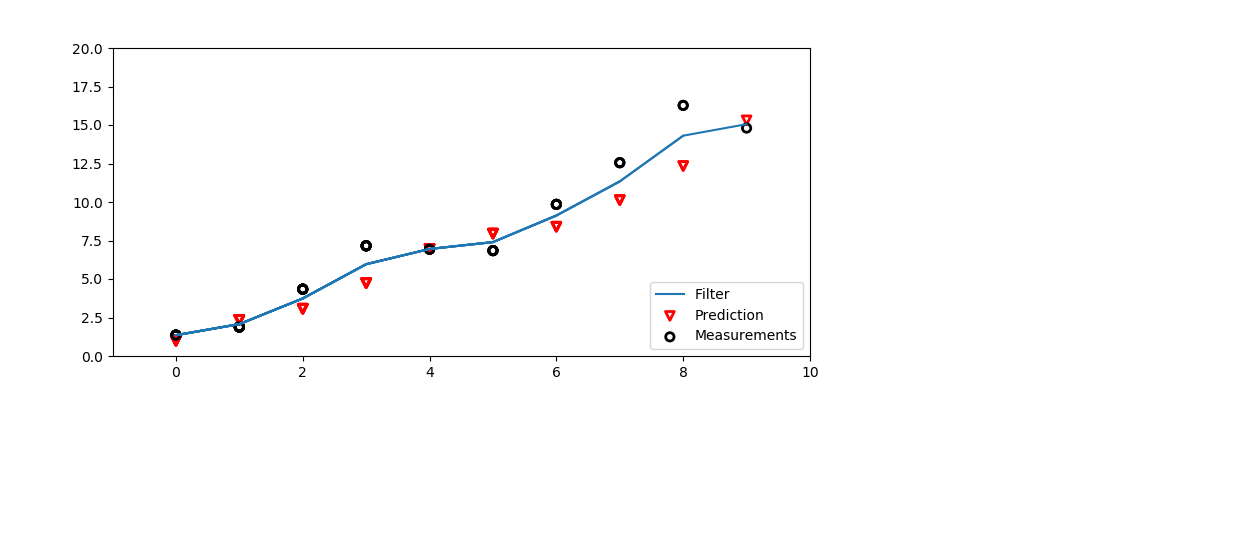

In [11]:
import time
from kf_book import book_plots as book_plots
from kf_book.book_plots import reset_figsize


# save output in these lists for plotting
xs, predictions = [], []

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)
    kf_internal.print_gh(prior, x, z)
    
%matplotlib notebook
fig = plt.figure(figsize=(9,4))
canvas = fig.canvas
time_step = .25
for i in range(2, len(xs)+1):

    book_plots.plot_predictions(predictions[:i])  
    plt.xlim(-1, 10)
    plt.ylim(0,20)
    fig.canvas.draw()
    time.sleep(time_step)

    book_plots.plot_measurements(zs[:i])
    plt.xlim(-1, 10)
    plt.ylim(0,20)
    fig.canvas.draw()
    time.sleep(time_step)

    book_plots.plot_filter(xs[:i])
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    fig.canvas.draw()
    time.sleep(time_step)
    
    if i == 2:
        plt.legend(loc=4);
# reset to noninteractive plot settings
%matplotlib inline
reset_figsize();

### Code Walkthrough

In this example I only plotted 10 data points so the output from the print statements would not overwhelm us. Now let's look at the filter's performance with more data. The variance is plotted as a lightly shaded yellow area between dotted lines. I've increased the size of the process and sensor variance so they are easier to see on the chart - for a real Kalman filter of course you will not be randomly changing these values.

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


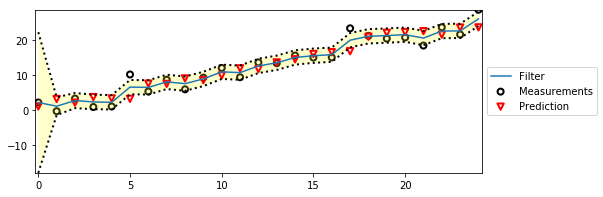

In [12]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

### KF Animation

![text](../animations/02_no_info.gif)

The top plot shows the output of the filter in green, and the measurements with a dashed red line. The bottom plot shows the Gaussian at each step.

When the track first starts you can see that the measurements varies quite a bit from the initial prediction. At this point the Gaussian probability is small (the curve is low and wide) so the filter does not trust its prediction. As a result, the filter adjusts its estimate a large amount. As the filter innovates you can see that as the Gaussian becomes taller, indicating greater certainty in the estimate, the filter's output becomes very close to a straight line. At x = 15 and greater you can see that there is a large amount of noise in the measurement, but the filter does not react much to it compared to how much it changed for the first noisy measurement.

### Kalman Gain

The posterior $x$ is computed as the likelihood times the prior ($\mathcal L \bar x$), where both are Gaussians.

Therefore the mean of the posterior is given by:

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$
I use the subscript $z$ to denote the measurement. We can rewrite this as:

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$
In this form it is easy to see that we are scaling the measurement and the prior by weights:

$$\mu = W_1 \mu_z + W_2 \bar\mu$$
The weights sum to one because the denominator is a normalization term. 

We introduce a new term, $K=W_1$, giving us:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
    &= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$
where

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$
$K$ is the Kalman gain. It's the crux of the Kalman filter. It is a scaling term that chooses a value partway between $\mu_z$ and $\bar\mu$.

Let's work a few examples. If the measurement is nine times more accurate than the prior, then $\bar\sigma^2 = 9\sigma_z^2$, and

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$
Hence $K = \frac 9 {10}$, and to form the posterior we take nine tenths of the measurement and one tenth of the prior.

If the measurement and prior are equally accurate, then $\bar\sigma^2 = \sigma_z^2$ and

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$
which is the average of the two means. It makes intuitive sense to take the average of two equally accurate values.

We can also express the variance in terms of the Kalman gain:

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$
We can understand this by looking at this chart:

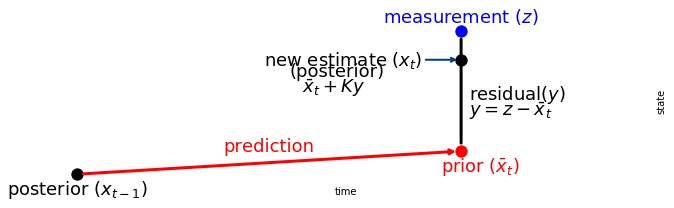

In [13]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

The Kalman gain $K$ is a scale factor that chooses a value along the residual. This leads to an alternative but equivalent implementation for update() and predict():

In [14]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

### Full Description of the Algorithm

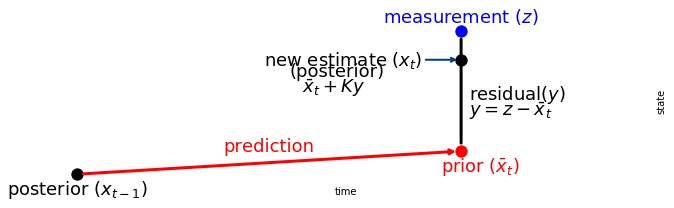

In [15]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

We've been doing the same thing in this chapter. The Kalman filter makes a prediction, takes a measurement, and then forms a new estimate somewhere between the two.

**This is extremely important to understand**: Every filter in this book implements the same algorithm, just with different mathematical details. The math can become challenging in later chapters, but the idea is easy to understand.

It is important to see past the details of the equations of a specific filter and understand what the equations are calculating and why. There are a tremendous number of filters. They all use different math to implement the same algorithm. The choice of math affects the quality of results and what problems can be represented, but not the underlying ideas.

Here is the generic algorithm:

Initialization

1. Initialize the state of the filter
2. Initialize our belief in the state

Predict

1. Use system behavior to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction

Update

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. Compute scaling factor based on whether the measurement
or prediction is more accurate
4. set state between the prediction and measurement based 
on scaling factor
5. update belief in the state based on how certain we are 
in the measurement

You will be hard pressed to find a Bayesian filter algorithm that does not fit into this form. Some filters will not include some aspects, such as error in the prediction, and others will have very complicated methods of computation, but this is what they all do.

The equations for the univariate Kalman filter are:

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$